# Vorhersage der elektrischen Leistung eines Windparks
# Einleitung

Im Folgenden wird ein künstlicher Datensatz behandelt, welcher die prognostischen meteorologischen Parameter und zugehörige gemessene Leistungserzeugung eines Windkraftparks enthält. Er umfasst 103392 Einträge mit jeweils 7 Spalten:

<ul>
<li>time: Zeitpunkt, für den die Vorhersage gilt bzw. an dem gemessen wurde</li>
<li>ptime: Zeitpunkt, zu dem die Prognose erstellt wurde</li>
<li>wind_direction: Windrichtung in Grad im Uhrzeigersinn von Norden</li>
<li>wind_direction Windgeschwindigkeit in m/s</li>
<li>temperature: Temperatur in K</li>
<li>pressure: Luftdruck in hPa und</li>
<li>power: gemessene Leistung der Anlage in kW</li>
</ul>

Ziel der Analyse ist das Erstellen und Evalueieren eines Modells, mit der sich aus den meteorologischen Daten die Leistung eines Windparks vorhersagen lässt.

**Keywords: Regression, Time Series Analysis**

# Modul Import

In [1]:
# Standardpakete
import pandas as pd
import numpy as np

# Tools zur Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# weiter Tools
from collections import Counter
from scipy.stats import uniform, loguniform, randint

# diverse Scikit-Learn Module
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

/home/sninfa/Dokumente/Job/Portfolio Projects/env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Lade & Inspiziere Datensatz

In [2]:
df = pd.read_csv('wind_power_data.csv', low_memory=False, thousands=',', sep=',')
df.head()

,time,ptime,wind_direction,wind_speed,temperature,pressure,power
0,2019-01-01 00:00:00,2018-12-31 06:00:00,293.198308,9.004684,275.698962,103353.718750,2707.0
1,2019-01-01 00:15:00,2018-12-31 06:00:00,292.102529,8.847332,275.636830,103343.753906,2749.0
2,2019-01-01 00:30:00,2018-12-31 06:00:00,291.005947,8.689980,275.574697,103333.789062,2566.0
3,2019-01-01 00:45:00,2018-12-31 06:00:00,289.909365,8.532627,275.512564,103323.824219,2613.0
4,2019-01-01 01:00:00,2018-12-31 06:00:00,288.813586,8.375275,275.450431,103313.859375,2602.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103392 entries, 0 to 103391
Data columns (total 7 columns):
time              103392 non-null object
ptime             103392 non-null object
wind_direction    103392 non-null float64
wind_speed        103392 non-null float64
temperature       102816 non-null float64
pressure          102816 non-null float64
power             99734 non-null float64
dtypes: float64(5), object(2)
memory usage: 5.5+ MB


Die Attribute time und ptime liegen im als Datentyp timestamp vor. In dieser Form sind sie für ein ML-Verfahren nicht verwertbar und müssen zu rein numerischen Typen umgewandelt werden bspw. Jahr, Monat, Tag, Stunde, Minute.

Eine möglicherweise betrachtenswerte Variable ist der zeitliche Abstand zwischen Prognose und Messung. Diese könnte dem Datenstatz hinzugefügt werden.

Das Attribut wind_direction enthält Werte aus dem zyklischen Zahlenraum 0°-360°. Durch die Aufspaltung in eine x- und y-Komponente wird die Zyklizität aufgehoben, welche für ein ML-Model unverständlich wäre. 

Die letzten drei Splaten enthalten offenbar fehlende Werte. Dies sollte untersucht werden.

In [4]:
print('Anzahl an fehlenden Werten für die Temperatur: %i' %(df.temperature.isna().sum()))
print('Anzahl an fehlenden Werten für den Druck: %i' %(df.pressure.isna().sum()))

Anzahl an fehlenden Werten für die Temperatur: 576
Anzahl an fehlenden Werten für den Druck: 576


In [5]:
df[df.temperature.isna() | df.pressure.isna()]

,time,ptime,wind_direction,wind_speed,temperature,pressure,power
56088,2019-07-16 18:00:00,2019-07-16 12:00:00,3.670746,5.560531,NaN,NaN,336.0
56089,2019-07-16 18:15:00,2019-07-16 12:00:00,2.870344,5.488279,NaN,NaN,591.0
56090,2019-07-16 18:30:00,2019-07-16 12:00:00,2.069629,5.416026,NaN,NaN,627.0
56091,2019-07-16 18:45:00,2019-07-16 12:00:00,1.268914,5.343774,NaN,NaN,674.0
56092,2019-07-16 19:00:00,2019-07-16 12:00:00,0.468512,5.271521,NaN,NaN,919.0
56093,2019-07-16 19:15:00,2019-07-16 12:00:00,2.493976,5.131695,NaN,NaN,487.0
56094,2019-07-16 19:30:00,2019-07-16 12:00:00,4.524528,4.991869,NaN,NaN,592.0
56095,2019-07-16 19:45:00,2019-07-16 12:00:00,6.555080,4.852043,NaN,NaN,618.0
56096,2019-07-16 20:00:00,2019-07-16 12:00:00,8.580545,4.712217,NaN,NaN,632.0
56097,2019-07-16 20:15:00,2019-07-16 12:00:00,11.151333,4.400012,NaN,NaN,459.0


In [6]:
Counter(df[df.temperature.isna() | df.pressure.isna()].ptime)

Counter({'2019-07-16 12:00:00': 72,
         '2019-08-04 18:00:00': 72,
         '2019-08-05 00:00:00': 72,
         '2019-08-26 00:00:00': 72,
         '2019-08-26 06:00:00': 72,
         '2019-08-26 12:00:00': 72,
         '2019-08-26 18:00:00': 72,
         '2019-08-27 00:00:00': 72})

Die ersten vier Attribute weisen keine fehlenden Werte auf. Für Temperatur und Luftdruck hingegen fehlen jeweils 576 Einträge. Diese können in diesem Fall nicht durch Imputation ersetzt werden, da es sich um zusammenhängende Lücken handelt, welche sich über 18h erstrecken. Es hat den Anschein, dass das meterologische Vorhersagesystem an einigen Tagen unvollständige Prognosen erzeugt hat (oder der Datensatz bewusst so manipuliert wurde...). Die Veränderung der Wetterdaten kann nicht ohne Weiteres interpoliert werden. Die entsprechenden Datenpunkte müssen verworfen werden.

Da es sich bei power um die gesuchte Zielgröße handelt, sind Einträge ohne einen Leistungswert völlig nutzlos. Sie sind weder zum Training noch zum Evaluieren des Models verwendbar. Derartige Einträge können verworfen werden. Hiervon gibt es 3658.

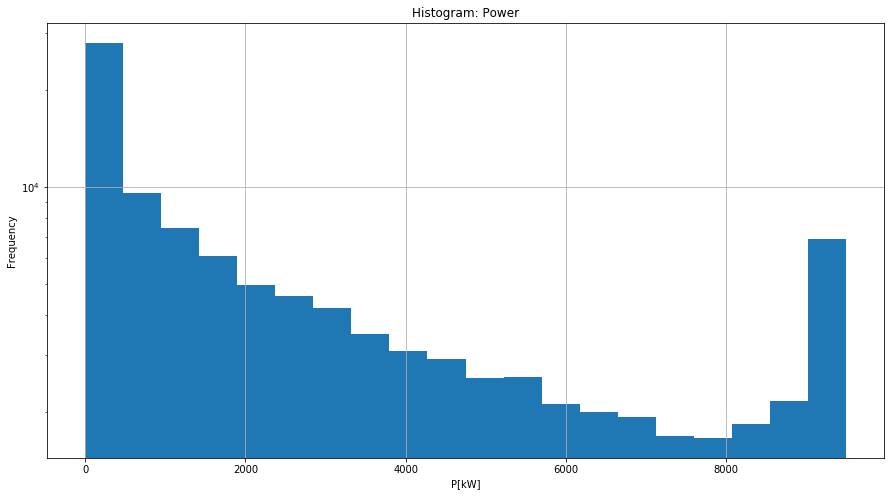

In [7]:
ax = df['power'].plot(kind = 'hist', figsize=(15,8), bins=20, log=True, title='Histogram: Power', grid=True)
plt.xlabel('P[kW]');

In [8]:
df[df.power > 9000].power.count() # Anzahl aller Einträge mit einem Wert für Power über 9000

6978

In [9]:
Counter(df.power).most_common(10)

[(0.0, 10052),
 (2.0, 594),
 (4.0, 307),
 (3.0, 259),
 (7.0, 203),
 (5.0, 188),
 (6.0, 154),
 (12.0, 125),
 (8.0, 122),
 (11.0, 119)]

Die Häufigkeiten für elektrische Leistungungswerte im Bereich von 0-8000kW nimmt exponentiell mit der Leistung ab. Hinzu kommt eine Häufung von 10052 Datenpunkten mit einer Leistung von genau null. Vermutlich waren die entsprechenden Anlagen zu diesem Zeitpunkt nicht im Betrieb, oder es bließ kein Wind. Ab 8000kW steigt die Häufigkeit von Werten mit wachsender Leistung. Jenseits der 9000kW-Marke liegt eine sehr ausgeprägte Häufung von Datenpunkten vor.

Insgesamt ist die numerische Verteilung der Leistung eher ungünstig, insbesondere mit Blick darauf, dass es sich hierbei um die zu bestimmende Zielgröße handelt. Die Vorhersagequalität eines Modells, welches auf diesen Daten trainiert wurde, wird in unterrepresentierten Wertebereichen vermutlich weniger gut ausfallen.

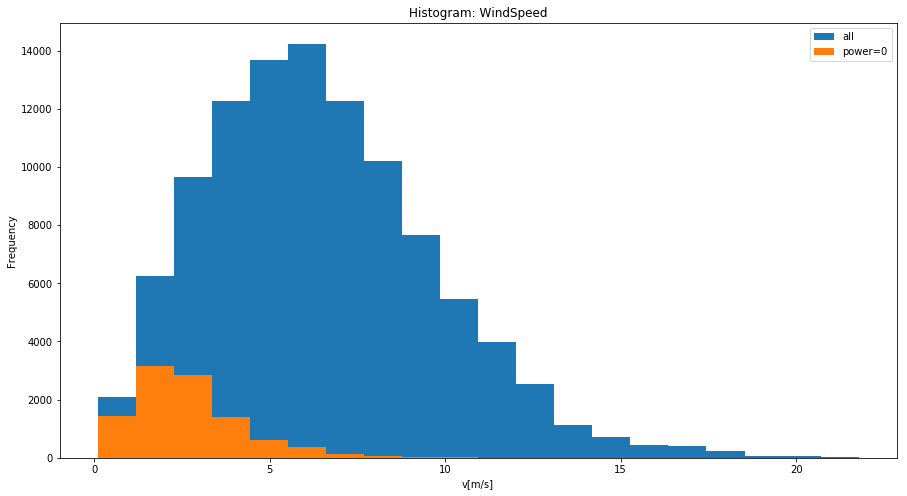

In [10]:
_, bins = np.histogram(df.wind_speed, bins=20)

f, ax = plt.subplots(figsize=(15, 8))
ax.set_xlabel('v[m/s]')
ax.set_title('Histogram: WindSpeed')
ax.grid(True)
df.wind_speed.plot(kind = 'hist', bins=bins, label='all', ax=ax)
df[df.power == 0].wind_speed.plot(kind = 'hist', bins=bins, label='power=0', ax=ax)
ax.legend();

Die Windgeschwindigkeit folgt einer Rayleigh-Verteilung, so wie es zu physikalisch zu erwarten wäre.

Bemerkenswert ist, dass die Windgeschwindigkeit bei Nullleistung zwar geringer ist, aber keineswegs vernachlässigbar.

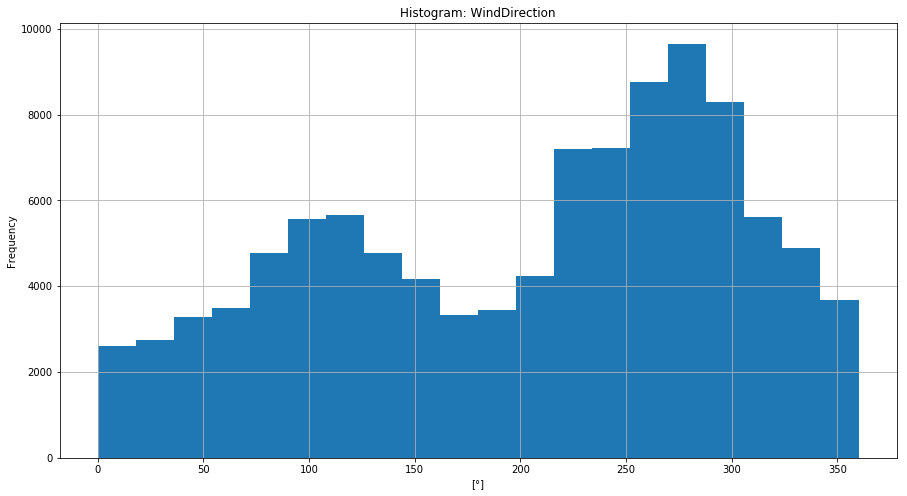

In [11]:
df['wind_direction'].plot(kind = 'hist', figsize=(15,8), bins=20, title='Histogram: WindDirection', grid=True)
plt.xlabel('[°]');

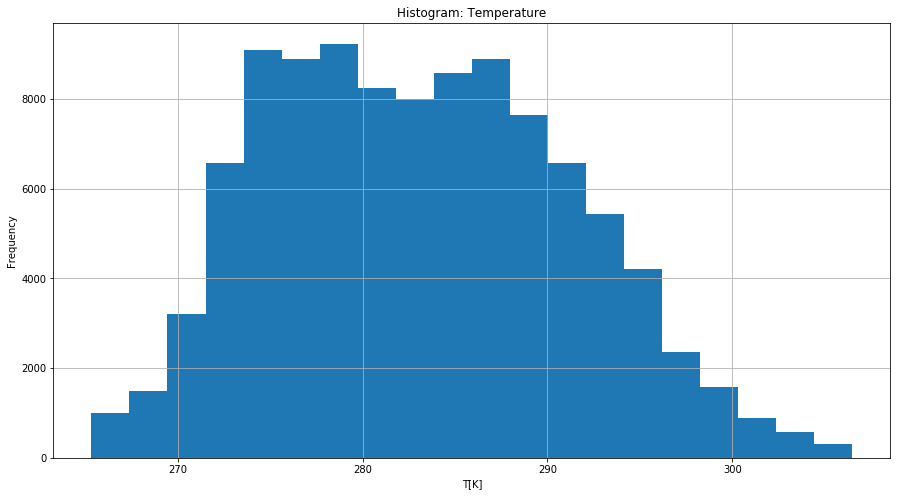

In [12]:
df['temperature'].plot(kind = 'hist', figsize=(15,8), bins=20, title='Histogram: Temperature', grid=True)
plt.xlabel('T[K]');

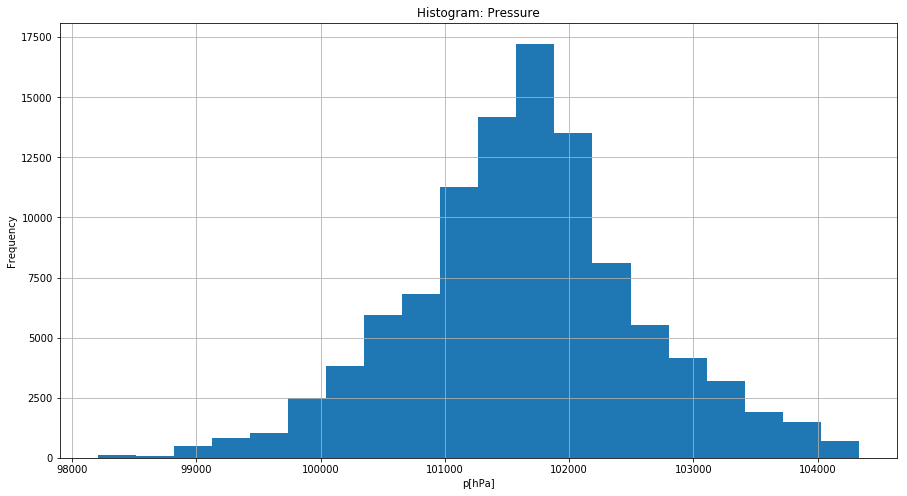

In [13]:
df['pressure'].plot(kind = 'hist', figsize=(15,8), bins=20, title='Histogram: Pressure', grid=True)
plt.xlabel('p[hPa]');

Der Luftdruck scheint einer einfachen Gauß-Verteilung zu folgen.
Die Werte für Temperatur und Windrichtung hingegen scheinen aus zwei verschiedenen Gauß-Populationen zu stammen. Erstere Beobachtung ist durch Temperaturschwankungen bedingt durch den Jahreszyklus erklärbar. Für die Windrichtung liegen die Erwartungswerte zu den beiden Populationen bei ca. 120° bzw. 270°, was vermuten lässt, dass der Wind vornehmlich aus diesen Richtungen bläst; also entweder von Westen oder Osten.

Alle Angaben zu etwaigen Wahrscheinlichkeitsverteilungen der Datenattribute müssten streng genommen mithilfe von Hypothesentest validiert werden. Da diese Information hier allerdings nicht vordergründig relevant ist, wird davon abgesehen.

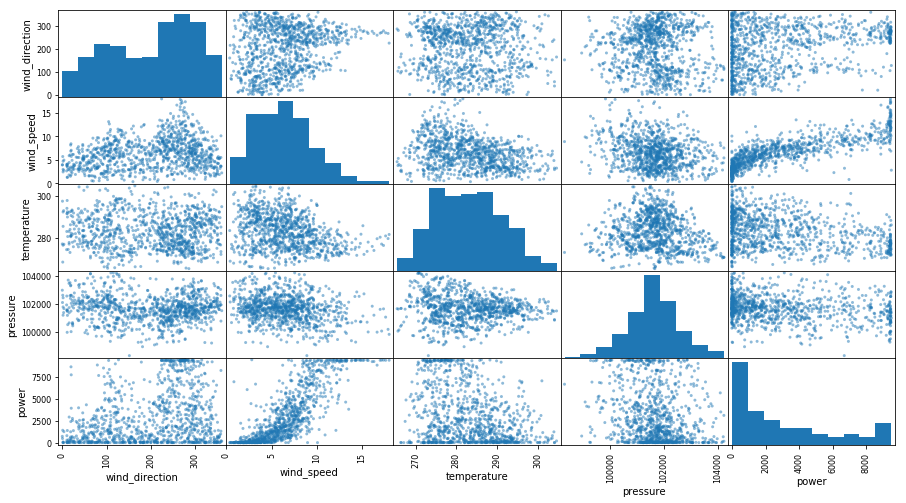

In [14]:
# nutze nur 1% der Daten um Rechenzeit zu sparen
pd.plotting.scatter_matrix(df[::100], figsize=(15,8));

In [15]:
df[::100].corr(method='spearman').style.background_gradient(cmap='coolwarm', axis=None)

,wind_direction,wind_speed,temperature,pressure,power
wind_direction,1,0.169572,-0.0348688,-0.0199648,0.236978
wind_speed,0.169572,1,-0.303275,-0.199084,0.840391
temperature,-0.0348688,-0.303275,1,-0.105969,-0.260634
pressure,-0.0199648,-0.199084,-0.105969,1,-0.218106
power,0.236978,0.840391,-0.260634,-0.218106,1


Das einzige Attribut, welches eine starke Korrelation zur Zielgröße power aufweist, ist wind_speed. Dies ist wenig überraschend. Zwischen beiden Größen besteht eine Spearman-Korrelation von 0,84. Anders als die standardmäßige Pearson-Korrelation kann die Spearman-Korrelation auch non-lineare Zusammenhänge aufzeigen.

Auch mit Blick auf die Scatter Matrix, lassen sich sonst keine weiteren Korrelationen erkennen.

Natürlich kann hierdurch nicht ausgeschlossen werden, dass die anderen Attribute auch einen signifikanten Einfluss auf die Leistung haben.

# Zeitreihenanalyse

In [16]:
df_new = df.copy()
df_new.time = pd.to_datetime(df_new.time)
df_new.ptime = pd.to_datetime(df_new.ptime)
df_new.index = df_new.time
df_new['year'] = df_new.index.year
df_new['month'] = df_new.index.month
df_new['hour'] = df_new.index.hour
df_new.head()

,time,ptime,wind_direction,wind_speed,temperature,pressure,power,year,month,hour
time,,,,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,2018-12-31 06:00:00,293.198308,9.004684,275.698962,103353.718750,2707.0,2019,1,0
2019-01-01 00:15:00,2019-01-01 00:15:00,2018-12-31 06:00:00,292.102529,8.847332,275.636830,103343.753906,2749.0,2019,1,0
2019-01-01 00:30:00,2019-01-01 00:30:00,2018-12-31 06:00:00,291.005947,8.689980,275.574697,103333.789062,2566.0,2019,1,0
2019-01-01 00:45:00,2019-01-01 00:45:00,2018-12-31 06:00:00,289.909365,8.532627,275.512564,103323.824219,2613.0,2019,1,0
2019-01-01 01:00:00,2019-01-01 01:00:00,2018-12-31 06:00:00,288.813586,8.375275,275.450431,103313.859375,2602.0,2019,1,1


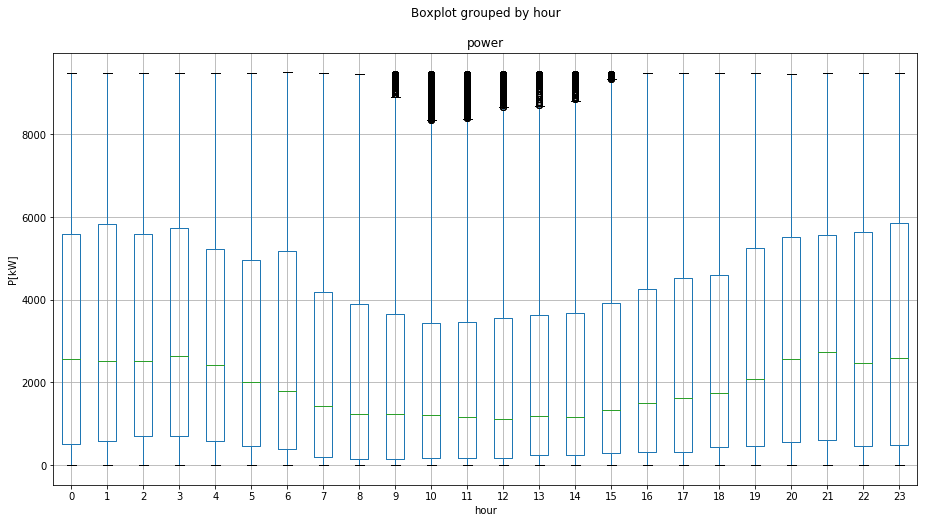

In [17]:
df_new.boxplot(column='power', by='hour', figsize=(15,8))
plt.ylabel('P[kW]');

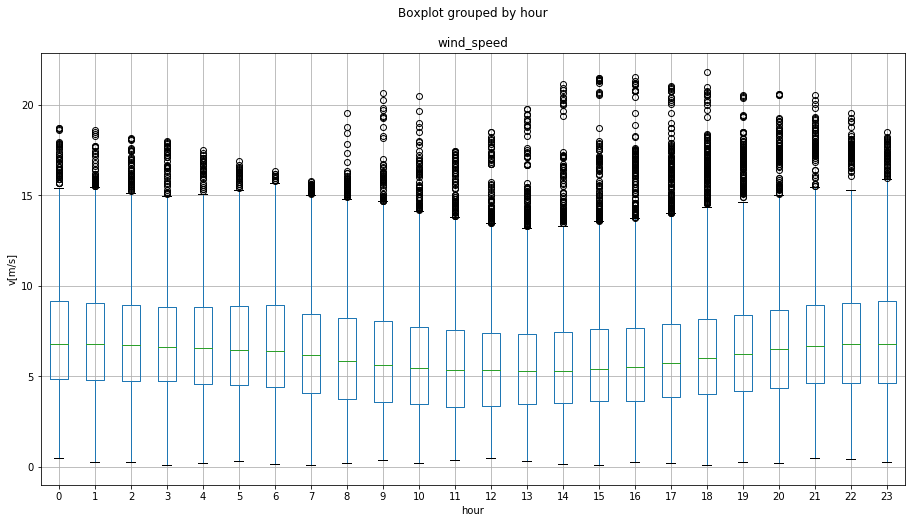

In [18]:
df_new.boxplot(column='wind_speed', by='hour', figsize=(15,8))
plt.ylabel('v[m/s]');

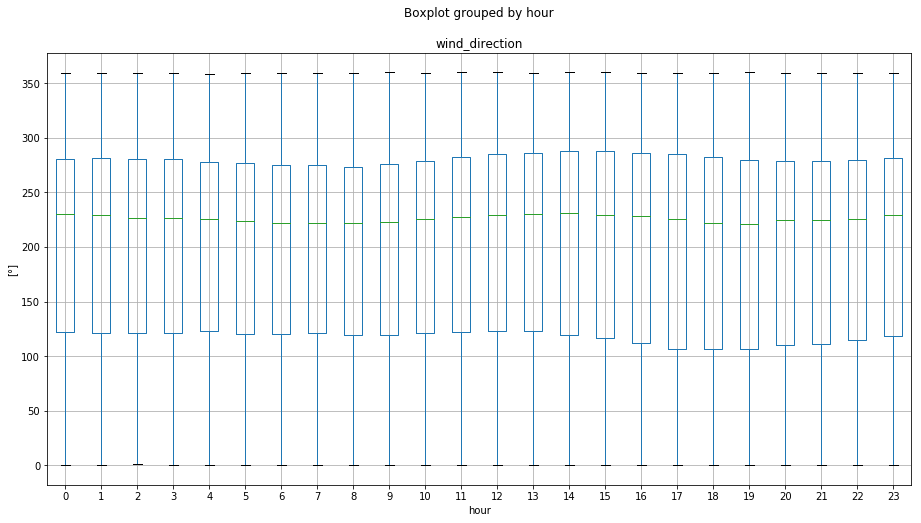

In [19]:
df_new.boxplot(column='wind_direction', by='hour', figsize=(15,8))
plt.ylabel('[°]');

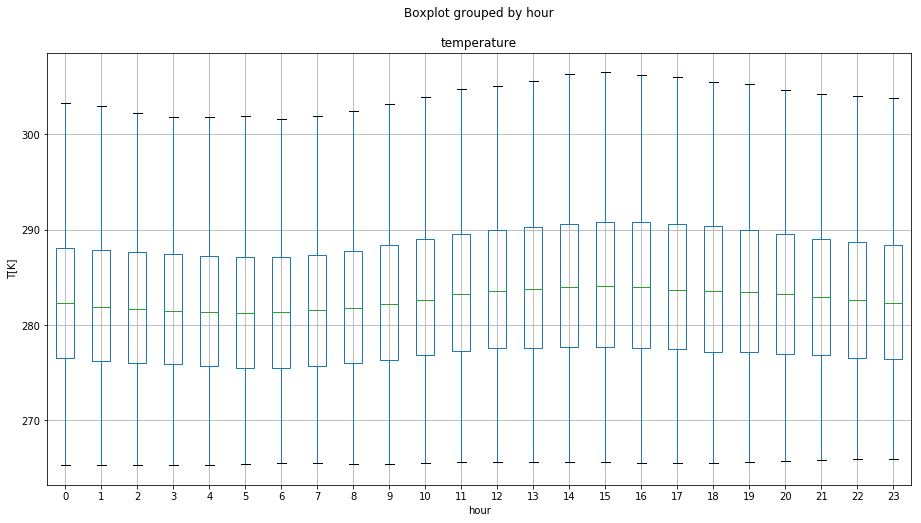

In [20]:
df_new.boxplot(column='temperature', by='hour', figsize=(15,8))
plt.ylabel('T[K]');

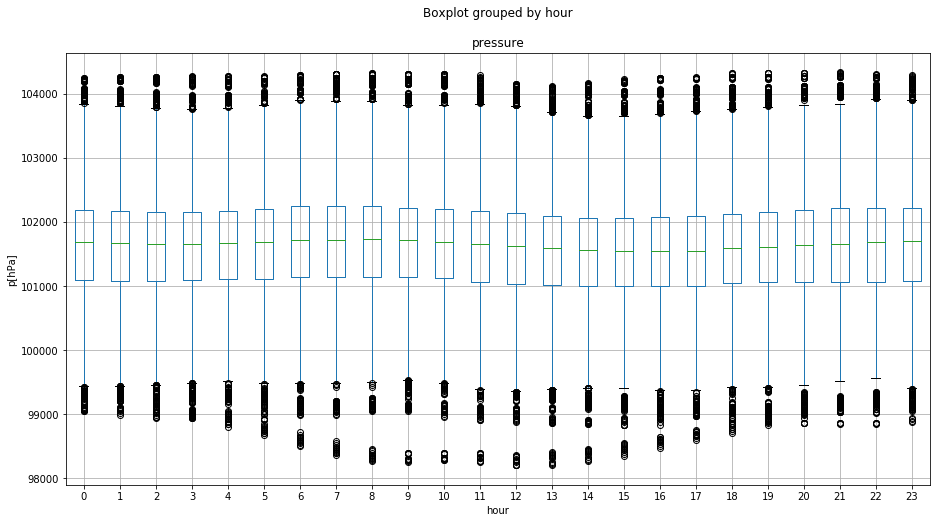

In [21]:
df_new.boxplot(column='pressure', by='hour', figsize=(15,8))
plt.ylabel('p[hPa]');

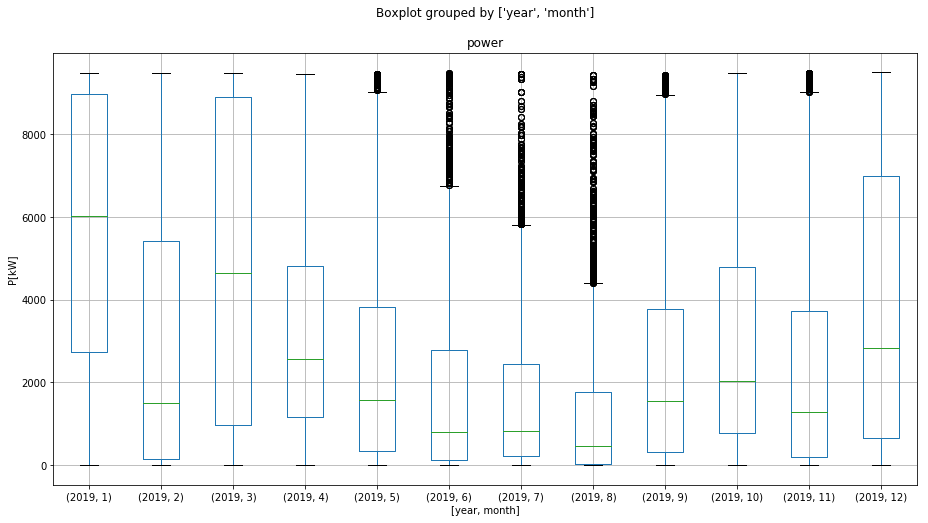

In [22]:
df_new.boxplot(column='power', by=['year', 'month'], figsize=(15,8))
plt.ylabel('P[kW]');

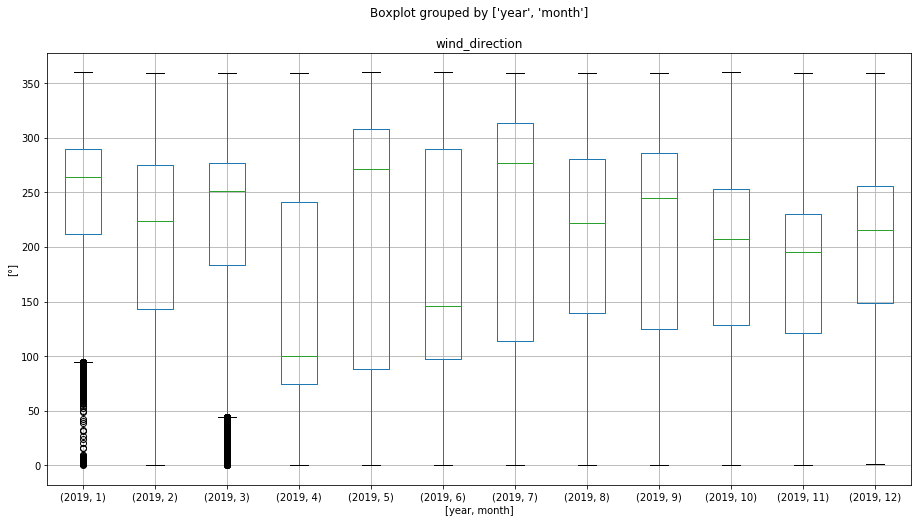

In [23]:
df_new.boxplot(column='wind_direction', by=['year', 'month'], figsize=(15,8))
plt.ylabel('[°]');

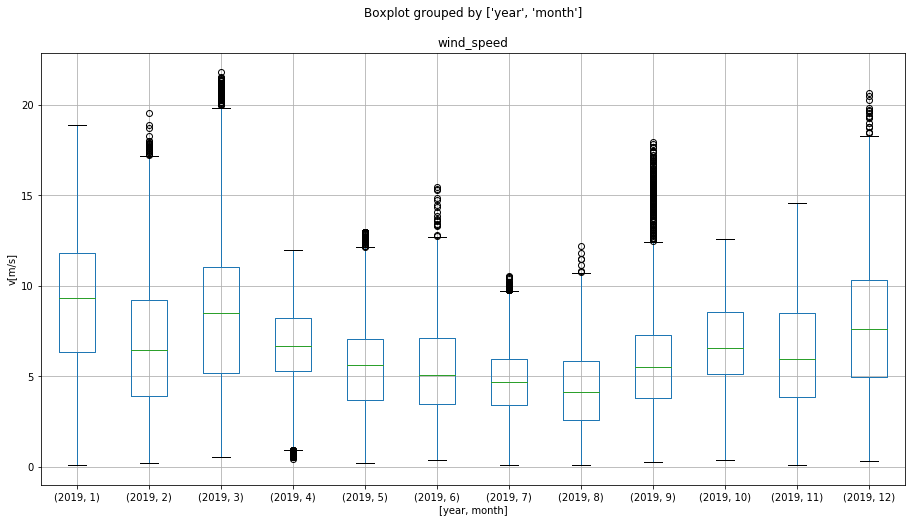

In [24]:
df_new.boxplot(column='wind_speed', by=['year', 'month'], figsize=(15,8))
plt.ylabel('v[m/s]');

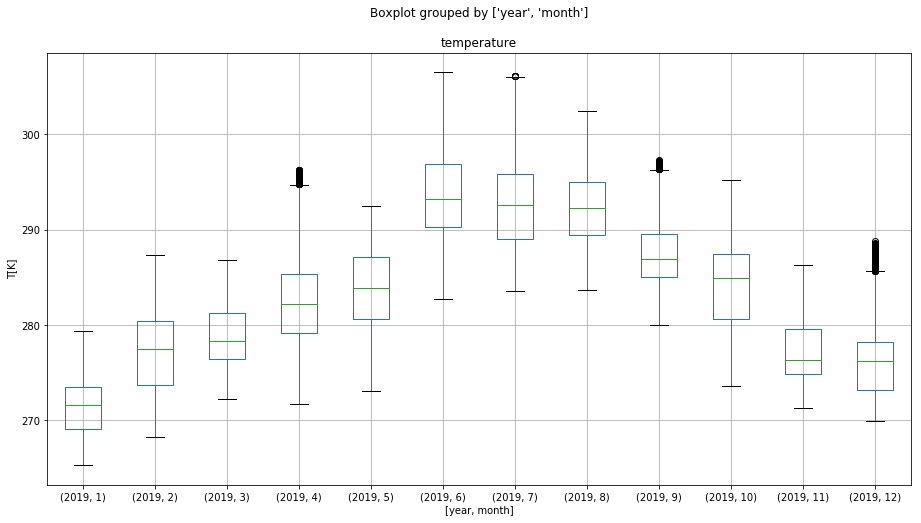

In [25]:
df_new.boxplot(column='temperature', by=['year', 'month'], figsize=(15,8))
plt.ylabel('T[K]');

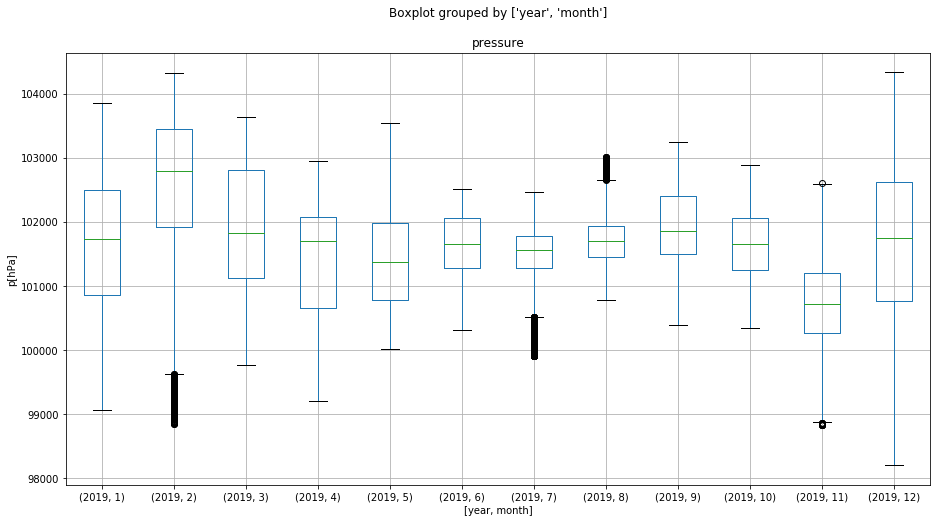

In [26]:
df_new.boxplot(column='pressure', by=['year', 'month'], figsize=(15,8))
plt.ylabel('p[hPa]');

Aus dem Vergleich der Zeitreihen für Leistung und Windgeschwindigkeit ist direkt ersichtlich, dass zwischen elektrischer Leistung und Windgeschwindigkeit ein positiver Zusammenhang besteht. Saisonal scheint ein Trend zu verringerten Windgeschwindigkeiten und Leistungen im Sommer zu bestehen. Derselbe Effekt ist tagsüber zu beobachten, wenn mittags im Schnitt weniger Wind weht.

Die Temperatur ist offensichtlich tagsüber und im Sommer deutlich erhöht gegenüber der Nacht und dem Winter.
Luftdruck und Windrichtung scheinen weder einem saisonalen noch tageszeitbedingten Trend zu folgen.

# Daten Vorverarbeitung

## bereinigen fehlender Werte und Aufspalten in Trainings- und Testdatensatz

In [27]:
# entferne nans und durchmische Datensatz
df_clean = shuffle(df.dropna(axis=0))

In [28]:
# spalte 20% der Daten als Test-Sample zur finalen Evaluation des Models ab
# trenne Zielgröße 'power' vom Rest des Datensatzes
train_set, test_set = train_test_split(df_clean, test_size=0.2, random_state=42)
    
# trenne Daten ohne Zielgröße (X) von Zielgröße (y)
X_train = train_set.drop(columns='power')
y_train = train_set['power']
X_test = test_set.drop(columns='power')
y_test = test_set['power']

## feature transformation

Wie oben beschrieben, sind die Windrichtung und die Zeitattribute keine Attribute, die von einem ML-Model sinnvoll interpretiert werden können. In einem ersten Schritt werden daher neue Attribute aus ihnen abgeleitet, während sie selber verworfen werden.

In [29]:
class BasicFeatureTransformer(BaseEstimator, TransformerMixin):
    '''
    -Transformerklasse für Zeitattribute und Windrichtung
    -spalte Windrichtung in x- und y-Komponenten auf
    -spalte Timestamps in numerische Komponenten auf (Jahr, Monat, etc.)
    -berechne Zeitspanne zwischen Prognose und wahrem Ereigniss
    -erwartet dataframe als input; gibt transformierten dataframe zurück
    -Wende 'fit_trandform' auf neue Daten direkt an. 'fit' tut nichst.
    --- X = transformer.fit_trandform(input_data) ---
    '''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_new = X.copy()
        
        # spalte Windrichtung in x- und y-Koordinate auf
        X_new['wind_direction_x'] = X_new.wind_direction.apply(np.radians).apply(np.sin)
        X_new['wind_direction_y'] = X_new.wind_direction.apply(np.radians).apply(np.cos)
        
        # überführe ins datetime-Format
        X_new.time = pd.to_datetime(X_new.time)
        X_new.ptime = pd.to_datetime(X_new.ptime)
        
        # füge neue Zeit-Attribute ein
        X_new['year'] = X_new.time.dt.year
        X_new['month'] = X_new.time.dt.month
        X_new['week'] = X_new.time.dt.week
        X_new['weekday'] = X_new.time.dt.weekday
        X_new['hour'] = X_new.time.dt.hour
        X_new['minute'] = X_new.time.dt.minute
        X_new['pyear'] = X_new.ptime.dt.year
        X_new['pmonth'] = X_new.ptime.dt.month
        X_new['pweek'] = X_new.ptime.dt.week
        X_new['pweekday'] = X_new.ptime.dt.weekday
        X_new['phour'] = X_new.ptime.dt.hour
        X_new['pminute'] = X_new.ptime.dt.minute
        
        # berechne Anzahl an Stunden zwischen Erstellen der Prognose und Messung
        X_new['hours_since_prog'] = (X_new.time - X_new.ptime) / np.timedelta64(1, 'h')
        
        # entferne alte Attribute und return
        return X_new.drop(columns=['time','ptime','wind_direction'])

Der Datensatz enthält sowohl kategorische als auch numerische Attribute. Obwohl in diesem Fall alle Attribute theoretisch als numerische Attribute aufgefasst werden könnten, sollten die Ergebnisse der Datumsaufspaltungen eher als kategorisch betrachtet werden. Obwohl eine ordinale Struktur vorliegt, ist sie nicht relevant, wenn nicht sogar störend.

Für echt numerische Attribute wird eine Reskalierung durchgeführt, um einheitliche Größenordnungen zu gewährleisten. Kategorische Attribute werden einer One-Hot-Enkodierung unterzogen, da die meißten ML-Algorithmen mit kategorischen Daten nicht direkt umgehen können.

In [30]:
# Festlegung numerischer Attribute
num_att = ['wind_direction_x',
       'wind_direction_y', 'wind_speed', 'temperature', 'pressure', 'hours_since_prog']

# Festlegung kategorischer Attribute
cat_att = ['year', 'month', 'week', 'weekday', 'hour', 'minute', 'pyear', 'pmonth',
       'pweek', 'pweekday', 'phour', 'pminute']

In [31]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # reskaliere Attribute auf Standartnormalverteilung
    ])

cat_pipeline = Pipeline([
        ("oneHot", OneHotEncoder()), # transformiere Kategorien in One-Hot kodierte Form
    ])

column_specific_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_att),
        ("cat", cat_pipeline, cat_att),
    ])

# Model Training

## Dummy Regressor

Um einen ersten Sanity-Check durchzuführen, wird zunächst ein Dummyregressor verwendet, um einen unteren Referenzwert für die Performance von Modellen festzulegen. 

In [32]:
# data pipeline für dummy regressor
# umfasst beide Level der Feature Transfromation und den Regressor im Anschluss
estimation_pipe = Pipeline([
    ("featureTransformer", BasicFeatureTransformer()),
    ("columnTransformer", column_specific_pipeline),
    ("estimator", DummyRegressor(strategy='mean')) # triviale Vorhersage basierend auf dem Mittelwert der Zielgröße
])

In [33]:
# 'trainiere' Modell auf Trainingsdaten
estimation_pipe.fit(X_train, y_train)

# erstelle Vorhersagen für Traingsdaten und evaluiere
y_pred = estimation_pipe.predict(X_train)

print('MAE: %f' %(mean_absolute_error(y_train, y_pred)))
print('EV Score: %f' %(explained_variance_score(y_train, y_pred)))
print('R2 Score: %f' %(r2_score(y_train, y_pred)))

MAE: 2529.971793
EV Score: 0.000000
R2 Score: 0.000000


Wie zu erwarten, ist die Vorhersagekraft des Dummymodells äußerst schlecht. Der Explained Variance Score und R2 Score liegen bei genau Null, da die Vorhersagen tatsächlich in keinem Zusammenhang mit der echten Zielgröße stehen.

Echte Modelle und deren Hyperparameter werden durch ein randomisiertes Verfahren trainiert und evaluiert.
Das beste Modell wird beibehalten und auf den Testdaten evaluiert.

Es werden folgende Regressormodelle in Betracht gezogen: ElasticNet, RandomForest, LinearSVM

In [34]:
@ignore_warnings(category=FitFailedWarning)
@ignore_warnings(category=ConvergenceWarning)
def fit_explore(X, y,
                estimator,
                param_distributions,
                n_iter=100,
                score='neg_mean_absolute_error',
                partition=100,
                cores=-1):
    '''
    Routine für die Hyperparamteroptimierung
    Führt für gegebne Klassifikator-Pipeline und Parameterset die Optimierung nach dem Zufallsprinzip aus.
    Training wärend des Optimierungsverfahrens wird mit einem verkleinertem Datenset (1/partition)
    durchgeführt um Zeit zu sparen.
    Anzahl an getesteten Parametersets gegeben durch 'n_iter'
    Scoring-Funktion optional wählbar.
    Scores werden mit m-facher Kreuzvalidierung ermittlet
    Model wird mit optimalen Hyperparametern und vollem Datensatz retrainiert.
    '''
    # definiere Suche
    rnd_search = RandomizedSearchCV(estimator, param_distributions=params,
                                n_iter=n_iter, cv=5, scoring=score, random_state=42, verbose=0, n_jobs=cores)

    # führe Suche aus
    rnd_search.fit(X[::partition], y[::partition])
    
    # retrainieren mit optimalen Hyperparametern
    estimator.set_params(**rnd_search.best_params_).fit(X, y)
    
    return estimator, rnd_search.best_params_

In [35]:
# data pipeline für dummy regressor
# umfasst beide Level der Feature Transfromation
# daran angeschlossen ist ein beliebiges Regressormodell mit vorgeschalteter Dimensionsreduktion
estimation_pipe = Pipeline([
    ("featureTransformer", BasicFeatureTransformer()),
    ("columnTransformer", column_specific_pipeline),
    ('DimRed', None),
    ('Estimator', None)
])

# Parameterverteilung aus der Hyperparametersets gezogen werden
params = [
    {
        'DimRed': [RFE(estimator=LinearSVR())],   # Dimensionsreduktion durch rekursive Feature Elimination
        'DimRed__n_features_to_select': randint(low=20, high=180),  # erlaube das Eliminieren von 0-160 Features
        'Estimator': [ElasticNet(random_state=42)],  # wähle ElasticNet als Regressor
        'Estimator__alpha': loguniform(1e-5, 10),  # wähle Regularisierungsstärke
        'Estimator__l1_ratio': uniform(0, 1)   # wähle L1/L2 Regularisierungsverhältniss
    },
    {
        'DimRed': [RFE(estimator=LinearSVR())],
        'DimRed__n_features_to_select': randint(low=20, high=180),
        'Estimator': [RandomForestRegressor(random_state=42)],  # wähle RandomForest als Regressor
        'Estimator__max_depth': randint(low=5, high=30),   # Tree Pruning durch Limitierung der Tiefe
        'Estimator__min_samples_split': randint(low=3, high=10)   # Mindestanzahl der Einträge in den Endknoten
    },
    {
        'DimRed': [RFE(estimator=LinearSVR())],
        'DimRed__n_features_to_select': randint(low=20, high=180),
        'Estimator': [LinearSVR()],     # wähle LinearSVM als Regressor
        'Estimator__C': loguniform(1e-5, 10),   # wähle Regularisierungsstärke
        'Estimator__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'] # wähle Regularisierungstyp
    }
]

# trainiere zufällig gewählte Modelle mit zufälligen Hyperparametern auf den Trainingsdaten
# behalte das beste Modell bei
best_model, best_config = fit_explore(X_train, y_train,
                                      estimator=estimation_pipe,
                                      param_distributions=params,
                                      n_iter=30,          # trainiere und evaluiere 30 Parametersets
                                      partition=10,     # nutze 10% der Daten
                                      score='r2',       # nutze R2 score zur Evaluierung
                                      cores=1)          # nutze nur einen CPU Kern

print(best_config)

# evaluiere bestes Modell auf eigenen Trainingsdaten
y_pred = best_model.predict(X_train)

print('MAE: %f' %(mean_absolute_error(y_train, y_pred)))
print('EV Score: %f' %(explained_variance_score(y_train, y_pred)))
print('R2 Score: %f' %(r2_score(y_train, y_pred)))

{'DimRed': RFE(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
                        intercept_scaling=1.0, loss='epsilon_insensitive',
                        max_iter=1000, random_state=None, tol=0.0001,
                        verbose=0),
    n_features_to_select=130, step=1, verbose=0), 'DimRed__n_features_to_select': 130, 'Estimator': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), 'Estimator__max_depth': 25, 'Estimator__min_samples_split': 4}
MAE: 243.271405
EV Score: 0.984107
R2 Score: 0.984107


Das beste gefundene Modell ist ein RAndomForest. Seine Perfromance auf den eigenen Trainingsdaten ist relativ gut, somit liegt zumindest kein Underfitting vor.

Um Overfitting auszuschließen, muss das Modell noch auf den bisher ungesehenen Testdaten evaluiert werden.

In [36]:
y_pred = best_model.predict(X_test)

print('MAE: %f' %(mean_absolute_error(y_test, y_pred)))
print('EV Score: %f' %(explained_variance_score(y_test, y_pred)))
print('R2 Score: %f' %(r2_score(y_test, y_pred)))

MAE: 493.226856
EV Score: 0.931719
R2 Score: 0.931716


Die Performance auf den Testdaten ist etwas schlechter, was für ein leichtes Overfitting spricht. Insgesammt ist die Vorhersageleistung jedoch noch akzeptabel.

Da sich die Zielgröße über mehrere Größenordnungen erstreckt, sollte die Performance des Models für verschiedene Wertebereiche der Leistung separat betrachtet werden. 

In [37]:
segmented_mae = {}

# betrachte die Zehnerquantile 0,1 bis 0,9 für die Zielgröße y des Testdatensatzes
for part in np.arange(0.1, 1., 0.1):
    upper_quantile = y_test.quantile(part)
    lower_quantile = y_test.quantile(part-0.1)
    
    # reduziere Datensatz auf Daten mit y zwischen Quantil(n-1) und Qunatil(n)
    if upper_quantile == lower_quantile:
        y = y_test[(y_test == upper_quantile)]
        X = X_test[(y_test == upper_quantile)]
    else:
        y = y_test[(y_test <= upper_quantile) & (y_test > lower_quantile)]
        X = X_test[(y_test <= upper_quantile) & (y_test > lower_quantile)]
    
    scores = []
    
    # berechne mittleren absoluten Fehler der Modellvorhersage mit 10-facher Kreuzvalidierung
    # nutze jeweils 50% der Daten geshuffled
    ssplit = ShuffleSplit(10, test_size=0.5, random_state=42)
    for idx, _ in ssplit.split(y):
        scores.append(mean_absolute_error(y.iloc[idx], best_model.predict(X.iloc[idx])))
    
    segmented_mae[np.floor(upper_quantile)] = scores

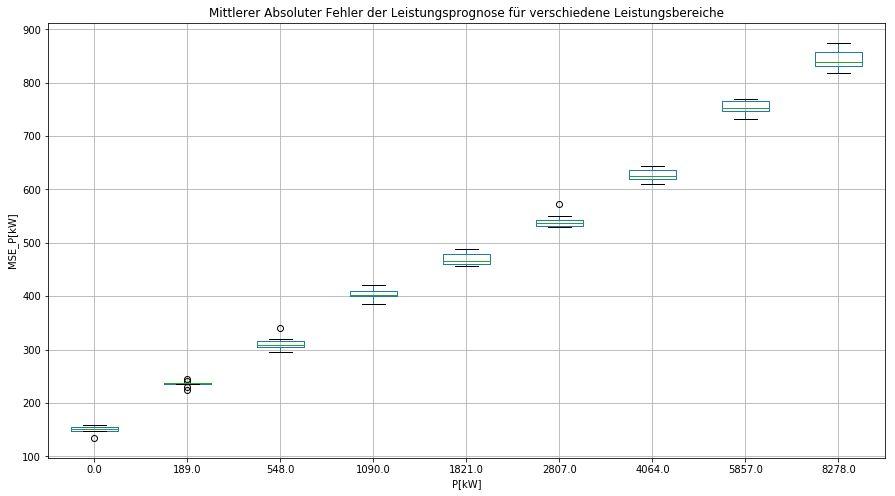

In [38]:
pd.DataFrame(segmented_mae).boxplot(figsize=(15,8));
plt.title('Mittlerer Absoluter Fehler der Leistungsprognose für verschiedene Leistungsbereiche')
plt.xlabel('P[kW]');
plt.ylabel('MSE_P[kW]');

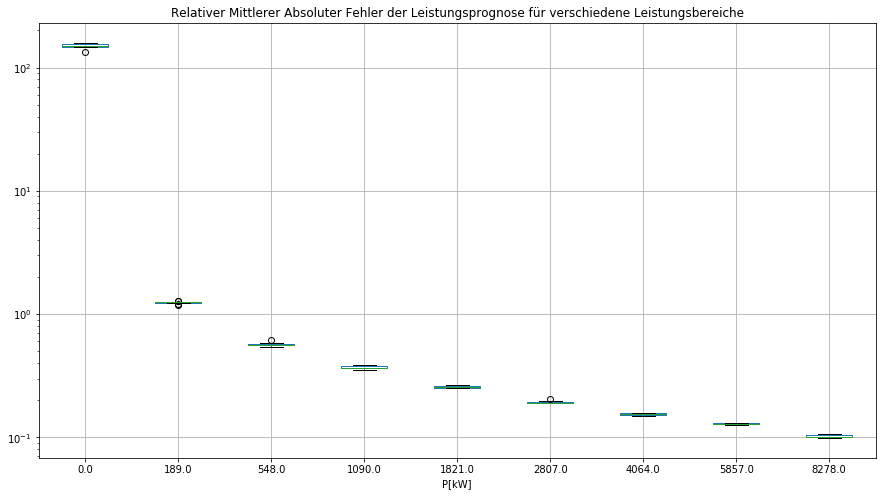

In [39]:
pd.DataFrame({key: value/(key+1) for key, value in segmented_mae.items()}).boxplot(figsize=(15,8));
plt.title('Relativer Mittlerer Absoluter Fehler der Leistungsprognose für verschiedene Leistungsbereiche')
plt.xlabel('P[kW]');
plt.yscale('log')

# Konklusion

Das beste gefunden Modell erzielt auf dem Tesdatensatz eine durchmischte Leistung. Für höhe Leistungen wird der relative Fehler der Vorhersage zunehmend kleiner, sodass für Leistungen oberhalb von ~2000kW Prognosen mit akzeptabler Präzision getroffen werden können. Für den Bereich kleinerer Leistungen ist das Modell eher ungeeignet. Vor allem bei Minimalleistungen nahe 0KW versagt das Modell völlig.

Insgesammt sind die Ergebisse jedoch vielversprechend. Mit mehr Rechenzeit könnte eine deutlich intensivere Hyperparametersuche durchgeführt werden, wodurch noch stärker optimierte Modelle gewonnen werden. Die allgemeine Vorhersagequalität kann so verbessert und das leichte Overfitting behoben werden.

Desweiteren könnte versucht werden mehrere Modelle für unterschiedliche Leistungsbereiche zu trainieren und diese miteinander zu kombinieren. Somit könnte eine konstant gute Performance über den gesamten Wertebereich erzielt werden.

Es scheint, dass die bisher erprobten Modelle bereits ausreichende Komplexität aufweisen um die Aufgabenstellung lösen zu können. Der Einsatz von Deep Learing erscheint in diesem Fall daher unnötig.